In [1]:
import pandas as pd
import pulp as plp
import numpy as np
from sklearn.metrics import accuracy_score

In [4]:
houses = pd.DataFrame(pd.read_csv('RWHOptimiser-master\Catchment_area.csv'))
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 3 columns):
Unnamed: 0    1111 non-null int64
x             1111 non-null float64
y             1111 non-null float64
dtypes: float64(2), int64(1)
memory usage: 26.1 KB


In [5]:
houses.head()
seti = range(len(houses))

In [7]:
TOTAL_CATCHMENT_AREA = 31 #Total catchment area in Delhi is close to 31 km^2 which is distributed among our houses
TOTAL_RAINWATER_COLLECTED = 18941 #This is calculated as average annual rainfall * total catchment area and is distributed as demands of houses
import random as ran
r1 = [ran.random() for i in seti]
s1 = sum(r1)
r1 = [ i/s1 for i in r1 ]
r1 = r1 * TOTAL_CATCHMENT_AREA
houses['catch_area_km_sq'] = pd.Series(r1)
r2 = [ran.random() for i in seti]
s2 = sum(r2)
r2 = [ i/s2 for i in r2 ]
r2 = r2 * TOTAL_RAINWATER_COLLECTED
houses['catch_area_km_sq'] = pd.Series(r1)
houses['demand_in_litres'] = pd.Series(r2)


In [8]:
# import seaborn as sns
# sns.scatterplot(data = houses[:1000])

import matplotlib.pyplot as plt
plt.scatter(x = houses['x'], y = houses['y'])
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
from sklearn.cluster import KMeans


In [10]:
kmeans = KMeans(n_clusters= 15)

In [11]:
someData=[] 
for x,y in zip(houses['x'].values, houses['y'].values):
    someData.append([x,y])
    

In [12]:
# kmeans.fit(houses['house_data_x'].values.reshape(-1, 1), y = houses['house_data_y'].values.reshape(-1, 1))
# print(houses[:,1])
# print(houses[:,2])
# arr = []
# for i in range(1111):
#     arr.append([houses[:,1][i], houses[:,2][i]])
#print(arr)
# kmeans.fit(arr)
clusters = kmeans.fit_predict(someData)

In [13]:
# clusters =kmeans.predict(houses['house_data_x'].values.reshape(-1, 1), houses['house_data_y'].values.reshape(-1, 1))

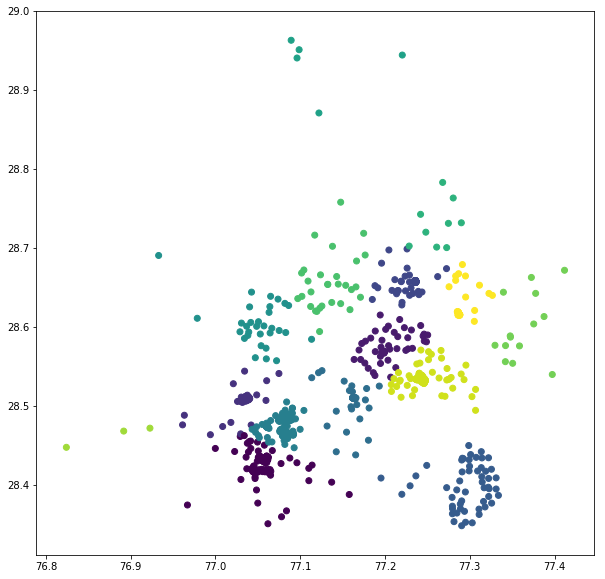

In [14]:
plt.figure(figsize = (10,10))

#plt.scatter(houses[:,1], houses[:,2], c = clusters)
plt.scatter(houses['x'], houses['y'], c = clusters)

In [15]:
centers = np.array(kmeans.cluster_centers_)
tanks = pd.DataFrame({'x' : centers[:, 0], 'y' : centers[:, 1]})

In [16]:
tanks['stability'] = np.random.normal(0.5, 0.2, len(tanks)) #assigning random values of stability to all tank locations
tanks

,x,y,stability
0,77.054079,28.425802,0.434926
1,77.203886,28.573486,0.358261
2,77.034000,28.507214,0.786968
3,77.231459,28.656596,0.361419
4,77.296437,28.398163,0.357784
5,77.162116,28.507787,0.858484
6,77.078970,28.475475,0.618868
7,77.051057,28.603416,0.839488
8,77.125333,28.934039,0.836254
9,77.262873,28.730600,0.453394


15

In [4]:
data = pd.read_csv('data.csv')
tanks_loc = pd.read_csv('tanks_loc.csv')

In [56]:
tanks_loc.head()

,tanks_x,tanks_y
0,77.216829,28.632630
1,77.279205,28.617980
2,77.170909,28.655077
3,77.205242,28.682151
4,77.293046,28.698714


In [ ]:
import math
PIPE_COST_PER_METRE = 120
seti = range(len(data))
setj = range(len(tanks_loc))
COST = [[] for i in range(len(tanks))]
def distance(j, i):
    a= (houses.loc[i, 'x'] - tanks.loc[j, 'x']) ** 2 
    b= (houses.loc[i, 'y'] - tanks.loc[j, 'y']) ** 2
    #Proper conversion function needs to be found to convert lat, long distance to metres
    return math.sqrt(a+b)

for j in setj:
    for i in seti:
        COST[j].append(distance(j, i) * PIPE_COST_PER_METRE) 
len(COST)

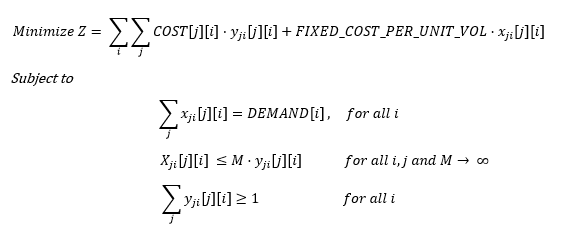

In [19]:
#SUPPLY ORIENTED APPROACH
lp_prob0 = pulp.LpProblem("LP0", pulp.LpMinimize)

# pipe from jth tank to ith house
yji = {
    (j, i): plp.LpVariable(
        cat = plp.LpBinary,
        name = "y_{0}_{1}".format(j,i)
    ) for j in setj for i in seti
}
# # Volume of water transported from jth tank to ith house
xji = {
    (j, i): plp.LpVariable(
        cat = plp.LpContinuous,
        lowBound = 0,
        upBound = None, # no upper bound
        name = "x_{0}_{1}".format(j, i)
    ) for j in setj for i in seti
}

# setting up the constraints

constraint_1 = {
    i : plp.LpConstraint(
        e = plp.lpSum(xji[j,i] for j in setj),
        sense = plp.LpConstraintEQ,
        rhs = houses['demand_in_litres'][i]
    ) for i in seti
}

constraint_2 = {
    (j,i) : plp.LpConstraint(
        e = xji[j,i],
        sense = plp.LpConstraintLE,
        rhs = M * yji[j,i]
    ) for j in setj for i in seti
}

constraint_3 = {
    i : plp.LpConstraint(
        e = plp.lpSum(yji[j,i] for j in setj),
        sense = plp.LpConstraintGE,
        rhs = 1
    ) for i in seti
}


In [20]:
objective = plp.lpSum(COST[j][i] * yji[j, i] + FIXED_CONST_COST_UNIT_VOL * xji[j, i] for i in seti for j in setj)

In [21]:
lp_prob0.setObjective(objective)
for i in seti:
    lp_prob0 += constraint_1[i]
for j in setj:
    lp_prob0 += constraint_2[j]

KeyError: 0

In [22]:
P0 = [0] * len(tanks)
status0 = lp_prob0.solve()
print(plp.LpStatus[lp_prob0.status])
if status0 == 1:
    for j in setj:
        SUPPLY[j] = 0
        for i in seti:
            SUPPLY[j] += xji[j,i]
            P0[j] = max(P0[j], yji[j,i])

Optimal


IndexError: list assignment index out of range

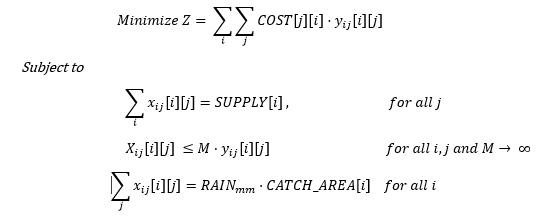

In [23]:
#DEMAND ORIENTED APPROACH
lp_prob = pulp.LpProblem("LP1", pulp.LpMinimize)
# pipe from ith house to jth tank
yij = {
    (i, j): plp.LpVariable(
        cat = plp.LpBinary,
        name = "y_{0}_{1}".format(i,j)
    ) for i in seti for j in setj
}
# # Volume of water transported from ith house to jth tank
xij = {
    (i, j): plp.LpVariable(
        cat = plp.LpContinuous,
        lowBound = 0,
        upBound = None, # no upper bound
        name = "x_{0}_{1}".format(i,j)
    ) for i in seti for j in setj
}
# setting up the constraints

constraint_1 = {
    j : plp.LpConstraint(
        e = plp.lpSum(xij[i,j] for i in seti),
        sense = plp.LpConstraintLE,
        rhs = SUPPLY[j]
    ) for j in setj
}

constraint_2 = {
    i : plp.LpConstraint(
        e = plp.lpSum(xij[i,j] for j in setj),
        sense = plp.LpConstraintEQ,
        rhs = RAIN * houses['area_per_house_metersq'][i]
    ) for i in seti
}

constraint_3 = {
    (i,j) : plp.LpConstraint(
        e = xij[i,j],
        sense = plp.LpConstraintLE,
        rhs = M * yij[i, j]
    ) for i in seti for j in setj
}

IndexError: list index out of range

In [24]:
objective = plp.lpSum(COST[j][i] * yij[i,j] for i in seti for j in setj)

In [25]:
lp_prob.setObjective(objective)
for j in setj:
    lp_prob += constraint_1[j]
for i in seti:
    lp_prob += constraint_2[i]
for i in seti:
    for j in setj:
        lp_prob += constraint_3[i, j]

KeyError: 0

In [26]:
P = [0] * NUMBER_TANKS
status = lp_prob.solve()
if status == 1:
    for j in setj:
        for i in seti:
            P[j] = max(P[j], yij[i,j])

NameError: name 'NUMBER_TANKS' is not defined

In [27]:
accuracy_score(np.array(P0), np.array(P))

NameError: name 'P' is not defined

In [31]:
import pulp
#M = len(houses)
M = len(data)
FIXED_CONST_COST_UNIT_VOL = 1000
SUPPLY = []

In [5]:
import math
PIPE_COST_PER_METRE = 120
seti = range(len(tanks_loc))
setj = range(len(data))
COST = [[] for i in range(len(tanks_loc))]
def distance(i, j):
    a= (data.loc[j, 'house_data_x'] - tanks_loc.loc[i, 'tanks_x']) ** 2 
    b= (data.loc[j, 'house_data_y'] - tanks_loc.loc[i, 'tanks_y']) ** 2
    #Proper conversion function needs to be found to convert lat, long distance to metres
    return math.sqrt(a+b)

for i in seti:
    for j in setj:
        COST[i].append(distance(i, j) * PIPE_COST_PER_METRE) 
len(COST)

59

In [32]:
import pulp as plp
lpProb = plp.LpProblem("LP")
zij = {
    (i, j) : plp.LpVariable(
        cat = plp.LpBinary,
        name = 'z_{0}_{1}'.format(i, j)
    ) for i in seti for j in setj
}
xi = {
    i : plp.LpVariable(
        cat = plp.LpBinary,
        name = 'x_{0}'.format(i)
    ) for i in seti
}
constraint_1 = {
    j : plp.LpConstraint(
        e = plp.lpSum(zij[i, j] for i in seti),
        sense = plp.LpConstraintEQ,
        rhs = 1,
        name = 'constraint_1_{0}'.format(j)
    ) for j in setj
}
constraint_2 = {
    i : plp.LpConstraint(
        e = plp.lpSum(zij[i, j] for j in setj),
        sense = plp.LpConstraintLE,
        rhs = M * xi[i],
        name = 'constraint_2_{0}'.format(i)
    ) for i in seti
}
objective = plp.lpSum(COST[i][j] * zij[i, j] for i in seti for j in setj)
objective = objective + plp.lpSum(FIXED_CONST_COST_UNIT_VOL * xi[i] for i in seti)
lpProb.sense = plp.LpMinimize
lpProb.setObjective(objective)
for j in setj:
    lpProb += constraint_1[j]
for i in seti:
     lpProb += constraint_2[i]
status = lpProb.solve()
print(status)

-1


In [33]:
for v in lpProb.variables():
    if(v.varValue>0.0):
        print(v.name,"=",v.varValue)

In [34]:
plp.pulpTestAll()

	 Testing zero subtraction
	 Testing inconsistant lp solution
	 Testing continuous LP solution
	 Testing maximize continuous LP solution
	 Testing unbounded continuous LP solution
	 Testing Long Names
	 Testing repeated Names
	 Testing zero constraint
	 Testing zero objective
	 Testing LpVariable (not LpAffineExpression) objective
	 Testing Long lines in LP
	 Testing LpAffineExpression divide
	 Testing MIP solution
	 Testing MIP solution with floats in objective
	 Testing MIP relaxation
	 Testing feasibility problem (no objective)
	 Testing an infeasible problem
	 Testing an integer infeasible problem
	 Testing column based modelling
	 Testing dual variables and slacks reporting
	 Testing fractional constraints
	 Testing elastic constraints (no change)
	 Testing elastic constraints (freebound)
	 Testing elastic constraints (penalty unchanged)
	 Testing elastic constraints (penalty unbounded)
* Solver <class 'pulp.solvers.PULP_CBC_CMD'> passed.
Solver <class 'pulp.solvers.CPLEX_DLL'> un

In [8]:
# Import PuLP modeller functions
from pulp import *
 
# list of nodes
nodes = [1,2,3,4]
 
# supply or demand of nodes
            #NodeID : [Supply,Demand]
nodeData = {1:[4,0],
            2:[0,0],
            3:[0,0],
            4:[0,4]}
 
# arcs list
arcs = [ (1,2),
         (1,3),
         (2,3),
         (2,4),
         (3,4)]
 
# arcs cost, lower bound and capacity
            #Arc : [Cost,MinFlow,MaxFlow]
arcData = { (1,2):[2,0,4],
            (1,3):[2,0,2],
            (2,3):[1,0,2],
            (2,4):[3,0,3],
            (3,4):[1,0,5] }
 
# Splits the dictionaries to be more understandable
(supply, demand) = splitDict(nodeData)
(costs, mins, maxs) = splitDict(arcData)
 
# Creates the boundless Variables as Integers
vars = LpVariable.dicts("Route",arcs,None,None,LpInteger)
 
# Creates the upper and lower bounds on the variables
for a in arcs:
    vars[a].bounds(mins[a], maxs[a])
 
# Creates the 'prob' variable to contain the problem data    
prob = LpProblem("Minimum Cost Flow Problem Sample",LpMinimize)
 
# Creates the objective function
prob += lpSum([vars[a]* costs[a] for a in arcs]), "Total Cost of Transport"
 
# Creates all problem constraints - this ensures the amount going into each node is 
# at least equal to the amount leaving
for n in nodes:
    prob += (supply[n]+ lpSum([vars[(i,j)] for (i,j) in arcs if j == n]) >=
             demand[n]+ lpSum([vars[(i,j)] for (i,j) in arcs if i == n])), \
            "Flow Conservation in Node %s"%n
 
# The problem data is written to an .lp file
prob.writeLP("simple_MCFP.lp")
 
# The problem is solved using PuLP's choice of Solver
status1 = prob.solve()
 
# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", value(prob.objective))
status1

Total Cost of Transportation =  14.0


1